In [1]:
import numpy as np 
from scipy.integrate import ode
from scipy.integrate import solve_ivp
from IPython.display import display 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 
import TKI_apoptosis 
import TKI_apoptosis_params
 
[speciesNames, tau, ymax, y0, w, n, EC50] = TKI_apoptosis_params.loadParams()

In [2]:
# ROS = 1
w_ros = w.copy()
w_ros[15] = 1 

# SOR = 1
w_sor = w.copy()
w_sor[4] = 1

tspan = [0, 50]

# run simulations
# t_eval = times at which to store the solution - must lie within t_span
base = solve_ivp(TKI_apoptosis.ODEfunc, tspan,  y0, args=(tau, ymax, w, n, EC50), t_eval=np.linspace(*tspan, 201))
ros = solve_ivp(TKI_apoptosis.ODEfunc, tspan,  y0, args=(tau, ymax, w_ros, n, EC50), t_eval=np.linspace(*tspan, 201))
sor = solve_ivp(TKI_apoptosis.ODEfunc, tspan,  y0, args=(tau, ymax, w_sor, n, EC50), t_eval=np.linspace(*tspan, 201))

/Volumes/SaucermanLab/Lavie/LRP1/Code/TKI_apoptosis.py:152: RuntimeWarning: invalid value encountered in scalar power
  fact = w*(beta*x**n)/(K**n+x**n)


In [3]:
# base.y.T = activity levels
# columns are species (69 total)
# use melt to turn activity levels into its own column based on species
# var_name = new column based on existing column names
# reset index and make new time column
base_df = pd.DataFrame(base.y.T, index = base.t, columns = speciesNames).melt(var_name='species', value_name = 'activity', ignore_index= False).reset_index(names = 'time')

# create new column to label condition
base_df['condition'] = 'base'

ros_df = pd.DataFrame(ros.y.T, index = ros.t, columns = speciesNames).melt(var_name='species', value_name = 'activity', ignore_index= False).reset_index(names = 'time')
ros_df['condition'] = 'ROS activation'


sor_df = pd.DataFrame(sor.y.T, index = sor.t, columns = speciesNames).melt(var_name='species', value_name = 'activity', ignore_index= False).reset_index(names = 'time')
sor_df['condition'] = 'SOR activation'

# merge all conditions into one df
results = pd.concat([base_df, ros_df, sor_df])
display(results) # print df

,time,species,activity,condition
0,0.00,Akt,0.000000e+00,base
1,0.25,Akt,1.134816e-11,base
2,0.50,Akt,1.368299e-08,base
3,0.75,Akt,7.073610e-07,base
4,1.00,Akt,1.006427e-05,base
...,...,...,...,...
13864,49.00,xIAPt,1.000000e+00,SOR activation
13865,49.25,xIAPt,1.000000e+00,SOR activation
13866,49.50,xIAPt,1.000000e+00,SOR activation
13867,49.75,xIAPt,1.000000e+00,SOR activation


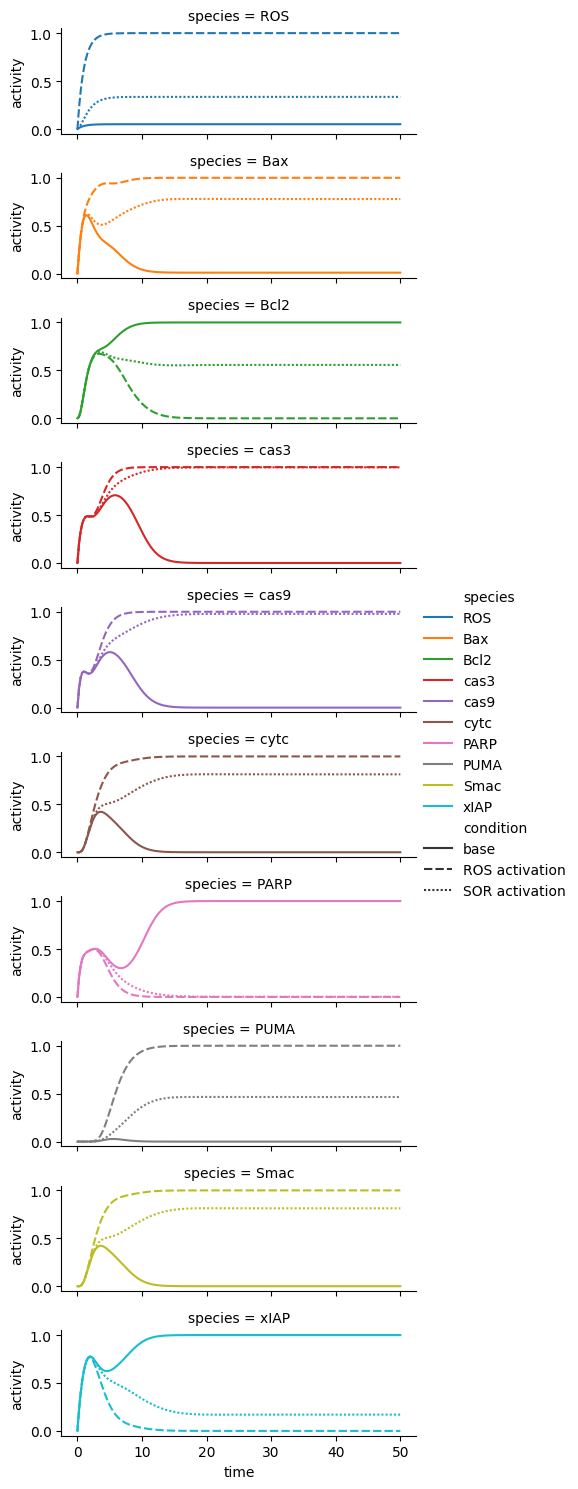

In [4]:
# choose species of interest based on paper (Fig. 2b)

species_2b = ['ROS', 'Bax', 'Bcl2', 'cas3', 'cas9', 'cytc', 'PARP', 'PUMA', 'Smac', 'xIAP']

activity_levels = sns.relplot(
    data = results,
    kind = 'line',
    x = 'time', y = 'activity',
    hue = 'species', hue_order = species_2b,
    style = 'condition',
    row = 'species', row_order = species_2b,
    height = 1.5, aspect = 3
)

# sensitivity analysis (difference in activity of all species due to knockdown or overexpression)

In [5]:
# re-pivot results table to organize by species
results_by_species = results.pivot(index=('time', 'species'), columns = 'condition').reset_index()

In [6]:
results_by_species

time species       activity                         
condition               ROS activation SOR activation      base
0           0.0     AP1   0.000000e+00       0.000000  0.000000
1           0.0    ASK1   0.000000e+00       0.000000  0.000000
2           0.0     Akt   0.000000e+00       0.000000  0.000000
3           0.0     Bad   0.000000e+00       0.000000  0.000000
4           0.0     Bax   0.000000e+00       0.000000  0.000000
...         ...     ...            ...            ...       ...
13864      50.0   iCADt   1.000000e+00       1.000000  1.000000
13865      50.0     p38   1.000000e+00       0.476081  0.003652
13866      50.0     p53   1.000000e+00       0.469401  0.000055
13867      50.0    xIAP   4.616743e-16       0.170206  0.999969
13868      50.0   xIAPt   1.000000e+00       1.000000  1.000000

[13869 rows x 5 columns]

In [9]:
# re-pivot results table to organize by species
results_by_species = results.pivot(index=('time', 'species'), columns = 'condition').reset_index()

# difference in activities between ros condition and baseline
results_by_species['activity', 'ros_diff'] = results_by_species['activity', 'ROS activation'] - results_by_species['activity', 'base']

In [10]:
results_by_species

time species       activity                                   
condition               ROS activation SOR activation      base  ros_diff
0           0.0     AP1   0.000000e+00       0.000000  0.000000  0.000000
1           0.0    ASK1   0.000000e+00       0.000000  0.000000  0.000000
2           0.0     Akt   0.000000e+00       0.000000  0.000000  0.000000
3           0.0     Bad   0.000000e+00       0.000000  0.000000  0.000000
4           0.0     Bax   0.000000e+00       0.000000  0.000000  0.000000
...         ...     ...            ...            ...       ...       ...
13864      50.0   iCADt   1.000000e+00       1.000000  1.000000  0.000000
13865      50.0     p38   1.000000e+00       0.476081  0.003652  0.996348
13866      50.0     p53   1.000000e+00       0.469401  0.000055  0.999945
13867      50.0    xIAP   4.616743e-16       0.170206  0.999969 -0.999969
13868      50.0   xIAPt   1.000000e+00       1.000000  1.000000  0.000000

[13869 rows x 6 columns]

In [11]:
# re-pivot results table to organize by species
results_by_species = results.pivot(index=('time', 'species'), columns = 'condition').reset_index()

# difference in activities between ros condition and baseline
results_by_species['activity', 'ros_diff'] = results_by_species['activity', 'ROS activation'] - results_by_species['activity', 'base']

# between SOR activation and baseline levels
results_by_species['activity', 'sor_diff'] = results_by_species['activity', 'SOR activation'] - results_by_species['activity', 'base']

# steady state levels
steady_states = results_by_species[results_by_species['time'] == tspan[1]]

In [12]:
# re-pivot results table to organize by species
results_by_species = results.pivot(index=('time', 'species'), columns = 'condition').reset_index()

# difference in activities between ros condition and baseline
results_by_species['activity', 'ros_diff'] = results_by_species['activity', 'ROS activation'] - results_by_species['activity', 'base']

# between SOR activation and baseline levels
results_by_species['activity', 'sor_diff'] = results_by_species['activity', 'SOR activation'] - results_by_species['activity', 'base']

# steady state levels
steady_states = results_by_species[results_by_species['time'] == tspan[1]]

In [13]:
steady_states

time species       activity                                     \
condition               ROS activation SOR activation      base  ros_diff   
13800      50.0     AP1   1.000000e+00       0.472952  0.000634  0.999366   
13801      50.0    ASK1   1.000000e+00       0.481276  0.031295  0.968705   
13802      50.0     Akt   5.668740e-01       0.191188  0.566874  0.000000   
13803      50.0     Bad   1.000000e+00       0.919845  0.425818  0.574182   
13804      50.0     Bax   1.000000e+00       0.778144  0.010435  0.989565   
...         ...     ...            ...            ...       ...       ...   
13864      50.0   iCADt   1.000000e+00       1.000000  1.000000  0.000000   
13865      50.0     p38   1.000000e+00       0.476081  0.003652  0.996348   
13866      50.0     p53   1.000000e+00       0.469401  0.000055  0.999945   
13867      50.0    xIAP   4.616743e-16       0.170206  0.999969 -0.999969   
13868      50.0   xIAPt   1.000000e+00       1.000000  1.000000  0.000000   

                     
condition  sor_diff  
13800      0.472318  
13801      0.449981  
13802     -0.375686  
13803      0.494026  
13804      0.767708  
...             ...  
13864      0.000000  
13865      0.472430  
13866      0.469347  
13867     -0.829763  
13868      0.000000  

[69 rows x 7 columns]

In [14]:
tspan[1]

50

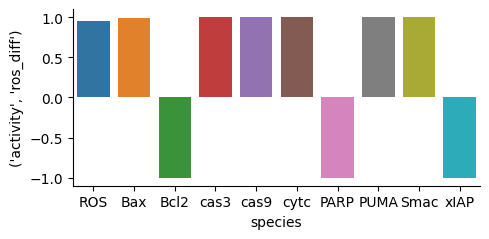

In [15]:
steady_diff = sns.catplot(
    data = steady_states,
    kind = 'bar',
    x = 'species', y = ('activity', 'ros_diff'),
    order = species_2b,
    hue_order = species_2b,
    hue = 'species',
    height = 2.5, aspect = 2
)

In [18]:
# pivot table based on species and time
# filter down to species of interest
results_by_time = results_by_species.pivot(index = 'species', columns = 'time', values=('activity','sor_diff')).loc[['Bad', 'Bax', 'cas9', 'cas3', 'CAD', 'PARP']]

In [19]:
results_by_time

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,...,47.75,48.00,48.25,48.50,48.75,49.00,49.25,49.50,49.75,50.00
species,,,,,,,,,,,,,,,,,,,,,
Bad,0.0,-7.238099e-13,-5.074779e-11,6.750325e-10,6.902353e-09,1.345571e-07,1.452155e-06,0.000010,0.000059,0.000164,...,0.494026,0.494026,0.494026,0.494026,0.494026,0.494026,0.494026,0.494026,0.494026,0.494026
Bax,0.0,4.002397e-07,3.921886e-05,4.494140e-04,2.104765e-03,6.081535e-03,1.309549e-02,0.023253,0.036162,0.051043,...,0.767708,0.767708,0.767708,0.767708,0.767708,0.767708,0.767708,0.767708,0.767708,0.767708
cas9,0.0,-8.320808e-11,7.686381e-10,7.796046e-08,1.855869e-06,1.756026e-05,9.254550e-05,0.000330,0.000953,0.002041,...,0.977747,0.977747,0.977747,0.977747,0.977747,0.977747,0.977747,0.977747,0.977747,0.977747
cas3,0.0,-8.263981e-11,-6.200004e-10,8.215657e-09,2.578999e-07,3.060814e-06,2.004964e-05,0.000087,0.000249,0.000698,...,0.997480,0.997480,0.997480,0.997480,0.997480,0.997480,0.997480,0.997480,0.997480,0.997480
CAD,0.0,-1.036934e-10,-1.667265e-10,5.625117e-09,7.307322e-09,2.760619e-08,3.214803e-07,0.000002,0.000121,0.000056,...,0.999701,0.999701,0.999701,0.999701,0.999701,0.999701,0.999701,0.999701,0.999701,0.999701
PARP,0.0,-8.954124e-11,-1.491826e-10,1.241254e-09,-1.856186e-08,-3.329979e-07,-2.701050e-06,-0.000014,0.000035,-0.000135,...,-0.997869,-0.997869,-0.997869,-0.997869,-0.997869,-0.997869,-0.997869,-0.997869,-0.997869,-0.997869


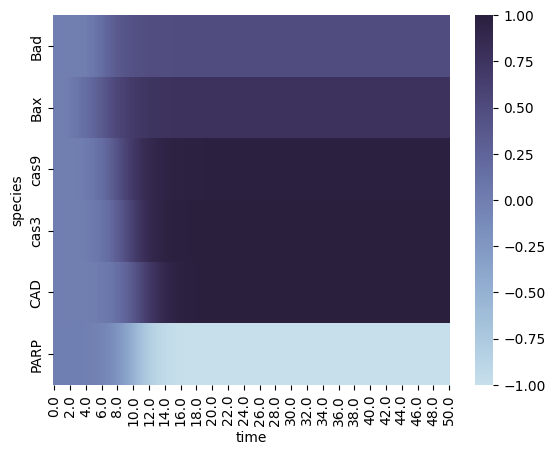

In [21]:
# pivot table based on species and time due to sor activation
# filter down to species of interest
results_by_time = results_by_species.pivot(index = 'species', columns = 'time', values=('activity','sor_diff')).loc[['Bad', 'Bax', 'cas9', 'cas3', 'CAD', 'PARP']]

sor_diff_time = sns.heatmap(
    data = results_by_time,
    cmap = sns.color_palette('ch:s=.25, rot=-.25', as_cmap=True),
    vmin = -1,
    vmax = 1
)